# <center>Titanic - Machine Learning from Disaster<center>

O objetivo deste trabalho é apresentar a minha solução para a competição **Titanic - Machine Learning from Disaster** presente no Kaggle.

Mais informações sobre a competição em : https://www.kaggle.com/competitions/titanic/overview/

Este notebook está dividido nos seguintes tópicos :

1. **Leitura dos Arquivos de Treino e Teste**
2. **Pré-processamento dos Dados**


    2.1 Observações Iniciais
    2.2 Tratamento de Valores Ausentes
        2.2.1 Age
        2.2.2 Cabin
        2.2.3 Embarked
        2.2.4 Fare
    2.3 Feature Scaling
3. **Feature Engineering**


    3.1 Tratamento de Variáveis Categóricas
        3.1.1 Sex
        3.1.2 Embarked
    3.2 Criação de Novas variáveis
        3.2.1 SibSp+Parch
        3.2.2 Pronome
        3.2.3 Cabin
        3.2.4 Ticket
4. **Modelagem**


    4.1 Acurácia no conjunto de treino
    4.2 Acurácia em Dados não vistos - Validação Cruzada
    4.3 Otimização de Hiperparâmetros através de Pesquisa em Grade
    4.4 Stacking
    4.5 Blending
        4.5.1 Submetendo ao Kaggle
5. **Comentários Finais**

In [1]:
# Algumas importações necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC , NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score , KFold , StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from IPython.display import Image

## <center>1. Leitura dos Arquivos de Treino e Teste<center>

In [2]:
# Transformando os arquivos de treino e teste em dataframes

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## <center>2. Pré-processamento dos Dados<center>

### 2.1 Observações Iniciais

In [3]:
# Tamanho do dataset de treino

df_train.shape

(891, 12)

In [4]:
# Observando as 5 primeiras linhas do dataset de treino

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Obtendo algumas estatísticas básicas de cada Feature 

df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Olhando para o tipo de dado de cada Feature para saber se precisamos modificar algum 

df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Tudo certo com os tipos de dado que a função pd.read_csv inferiu da base de dados disponibilizada pelo Kaggle .

Após termos feito uma observação inicial vamos para uma parte importante do projeto : Tratar os dados ausentes.

### 2.2 Tratamento de Valores Ausentes

O tratamento de dados ausentes é parte essencial de qualquer projeto de Ciência de Dados uma vez que os modelos disponibilizados pela biblioteca Scikit-Learn **não possuem suporte para serem treinados em conjuntos com valores ausentes (NaN)**. Sendo assim sempre torna-se necessário traçar uma estratégia de imputação de dados .

In [7]:
# Analisando quais colunas possuem valores ausentes no dataset de treino e quantos são esses valores

df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Analisando quais colunas possuem valores ausentes no dataset de teste e quantos são esses valores

df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### 2.2.1 Feature Age

In [9]:
# Observando a coluna Age

df_train['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

Conforme visto a cima são 177 valores ausentes na coluna Age . Vamos substituir esses valores ausentes pela média dessa coluna (obviamente para o cálculo da média utilizaremos somente os dados que não são NaN).

In [10]:
idade_média = df_train['Age'].mean()

In [11]:
idade_média

29.69911764705882

In [12]:
# Imputando a idade média nos valores ausentes

df_train.loc[df_train['Age'].isnull() , 'Age'] = idade_média

In [13]:
# De fato não temos mais nenhum valor ausente na coluna Age

sum(df_train['Age'].isnull())

0

Ao final deste projeto faremos prediçoes no conjunto de teste logo este também não pode ter valores ausentes . Devemos então replicar todas as mudanças feitas no nosso conjunto de treino no nosso conjunto de teste.

In [14]:
# Descobrindo quantos valores ausentes temos na coluna Age do conjunto de teste

sum(df_test['Age'].isnull())

86

In [15]:
# Imputando a idade média do conjunto de treino no nosso dataset de teste

df_test.loc[df_test['Age'].isnull() , 'Age'] = idade_média

In [16]:
# Repare como não temos mais valores ausentes na coluna Age do dataset de teste

sum(df_test['Age'].isnull())

0

#### 2.2.2 Cabin

In [17]:
# Observando a coluna Cabin

df_train['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

De um total de 891 amostras presentes no conjunto de treino temos 687 NaNs . Aqui não faremos nenhuma imputação e sim criaremos
uma nova variável que indica para cada amostra se temos ou se não temos a informação da cabine. Isso será feito no tópico de Feature Engineering.

#### 2.2.3 Embarked

In [18]:
# Observando quantos são os possíveis valores da variável categórica Embarked e qual a sua distribuição

df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Como temos apenas dois valores ausentes para Embarked vamos imputar nesses valores ausentes a categoria mais comum que é **S** conforme visto a cima .

In [19]:
df_train.loc[df_train['Embarked'].isnull() , 'Embarked'] = 'S'

In [20]:
# Não temos mais valores NaN na coluna Embarked

sum(df_train['Embarked'].isnull())

0

#### 2.2.4 Fare

Fare é uma variável numérica e possui somente um valor ausente . Vamos imputar nesse valor ausente a mediana já que 75% dos valores de Fare são inferiores a 31 e a média de Fare é aproximadamente 32.2 . Aqui não deve fazer muita diferença imputar a mediana ou a média já que temos apenas um valor ausente.

In [21]:
fare_median = df_train['Fare'].median()

In [22]:
df_test.loc[df_test['Fare'].isnull() , 'Fare'] = fare_median

In [23]:
# Não temos mais valores NaN na coluna Fare

sum(df_test['Fare'].isnull())

0

### 2.3 Feature Scaling

<p style='text-align: justify;'> Feature Scaling ou Dimensionamento de Recursos é quase sempre uma parte essencial de um projeto a não ser que estejamos treinando somente árvores de decisão por exemplo .Algumas variáveis possum variância alta (assumem valores em um intervalo muito grande) e isso acaba por impactar o treinamento dos modelos uma vez que muitos algoritmos de Machine Learning calculam distâncias entre os pontos das amostras e se os dados estiverem em escalas diferentes teremos valores muito elevados o que causará problemas em nossas previsões.</p>
    
    
<p style='text-align: justify;'>Existem várias maneiras de padronizar a escala de nossas features, porém vamos escolher a função StandardScaler do Scikit-Learn para obrigar cada variável a ter média 0 e desvio-padrão 1 (aproximar uma distribuição normal) e além é claro de diminuir o range da variável. </p>


In [24]:
# Instanciando o método

SS = StandardScaler()

As variáveis que possuem um range de valores elevado são Age e Fare e, por isso, vamos dimensioná-las. Criaremos duas novas colunas nos conjuntos de treino e teste : Age_SS e Fare_SS .

Optamos por criar duas novas colunas, pois as colunas Age e Fare sem dimensionamento podem ser úteis para criarmos novas variáveis em algum momento do projeto.

In [25]:
# Aplicando StandardScaler nos datasets de treino e teste

df_train['Age_SS'] = SS.fit_transform(df_train[['Age']])
df_test['Age_SS'] = SS.fit_transform(df_test[['Age']])
df_train['Fare_SS'] = SS.fit_transform(df_train[['Fare']])
df_test['Fare_SS'] = SS.fit_transform(df_test[['Fare']])

In [26]:
# Funciona !

np.mean(df_train['Age_SS']) , np.std(df_train['Age_SS'])




(2.5627959662152535e-16, 1.0000000000000009)

## <center>3. Feature Engineering<center>

### 3.1 Tratamento de Variáveis Categóricas

<p style='text-align: justify;'>Variáveis categóricas são variáveis não numéricas que podem ser divididas em categorias . Infelizmente o Scikit-Learn não aceita dados que não sejam numéricos em seus modelos e, por isso, precisamos transformar esses dados categóricos em dados numéricos. Temos duas variáveis categóricas no dataset do Titanic : Sex e Embarked.</p>

#### 3.1.1 Sex

A variável Sex possui duas categorias : male e female. Vamos criar uma nova coluna Sex_encoding que fornece o valor 1 para male e 0 para female.

In [27]:
# Utilizando LabelEncoder para criar a coluna Sex_encoding nos conjuntos de treino e teste

df_train['Sex_encoding'] = LabelEncoder().fit_transform(df_train['Sex'])
df_test['Sex_encoding'] = LabelEncoder().fit_transform(df_test['Sex'])

In [28]:
# Funciona !
df_train[['Sex' , 'Sex_encoding']].head()

,Sex,Sex_encoding
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


#### 3.1.2 Embarked

A variável Embarked possui 3 categorias : S , C e Q. Poderíamos criar uma variável que fornece o valor 0 para S, 1 para C e 2 para Q, porém dessa forma estaríamos dando um peso para cada categoria e, assim, nosso modelo poderia, por exemplo, interpretar que a variável Q é mais importante que as outras. Sendo assim, a melhor abordagem é criarmos 3 novas variáveis usando a função get_dummies do pandas.

In [29]:
pd.get_dummies(df_train['Embarked'])

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


<p style='text-align: justify;'>A variável C indica se o porto de embarque é o porto C ou não . Se o porto de embarque for o C então a variável C recebe o valor 1, se não for a variável C recebe o valor 0 . O processo é idêntico para as variáveis Q e S . Repare por exemplo que na primeira linha temos C = 0 , Q = 0 e S = 1 o que nos indica que o porto de embarque foi o S.</p>

In [30]:
# Anexando as variáveis C, Q e S ao dataset de treino

df_train = pd.concat([df_train , pd.get_dummies(df_train['Embarked'])] , axis = 1)

In [31]:
df_train[['Embarked' , 'C' , 'Q' , 'S']].head()

,Embarked,C,Q,S
0,S,0,0,1
1,C,1,0,0
2,S,0,0,1
3,S,0,0,1
4,S,0,0,1


In [32]:
# Repetindo o processo para o dataset de teste

df_test = pd.concat([df_test , pd.get_dummies(df_test['Embarked'])] , axis = 1)

In [33]:
df_test[['Embarked' , 'C' , 'Q' , 'S']].head()

,Embarked,C,Q,S
0,Q,0,1,0
1,S,0,0,1
2,Q,0,1,0
3,S,0,0,1
4,S,0,0,1


### 3.2 Criação de Novas Variáveis

#### 3.2.1 SibSp+Parch

<p style='text-align: justify;'>SibSp refere-se ao número de irmãos + cônjuges de cada indivíduo presentes no Titanic e Parch refere-se à quantidade total entre filhos, pai e mãe presentes no Titanic. É de se esperar que a soma SibSp+Parch seja uma variável com valor preditivo quando se quer prever se alguém sobreviveu ou não. Vamos então criar a variável SibSp+Parch.</p>

In [34]:
# Criando SibSp+Parch

df_train['SibSp+Parch'] = df_train['SibSp'] + df_train['Parch']
df_test['SibSp+Parch'] = df_test['SibSp'] + df_test['Parch']

#### 3.2.2 Pronome

Vamos prestar atenção na coluna Name :

In [35]:
df_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

<p style='text-align: justify;'>Repare que cada nome possui um pronome de tratamento e é bem possível que esse pronome de tratamento possua bom valor preditivo já que indivíduos com o pronome Mrs., por exemplo, geralmente possuem idade superior a indivíduos com o pronome Miss. e sabemos que a idade é um fator importante na sobrevivência ao desastre do Titanic. Portanto vamos criar uma variável chamada Pronome que contém o pronome presente no nome de cada indivíduo. Os pronomes Mr. , Miss. , Mrs. e Master são os pronomes que mais aparecem logo se um desses pronomes não estiver no nome do indivíduo a variável Pronome receberá o valor 'Outro'. </p>

In [36]:
df_train['Name'].str.split()

0                           [Braund,, Mr., Owen, Harris]
1      [Cumings,, Mrs., John, Bradley, (Florence, Bri...
2                             [Heikkinen,, Miss., Laina]
3      [Futrelle,, Mrs., Jacques, Heath, (Lily, May, ...
4                          [Allen,, Mr., William, Henry]
                             ...                        
886                            [Montvila,, Rev., Juozas]
887                    [Graham,, Miss., Margaret, Edith]
888       [Johnston,, Miss., Catherine, Helen, "Carrie"]
889                           [Behr,, Mr., Karl, Howell]
890                              [Dooley,, Mr., Patrick]
Name: Name, Length: 891, dtype: object

In [37]:
# Extraindo o pronome de cada nome e colocando na lista pronomes

pronomes = []
for i in df_train['Name'].str.split() :
    if 'Mr.' in i :
        pronomes.append('Mr.')
    elif 'Miss.' in i :
        pronomes.append('Miss.')
    elif 'Mrs.' in i :
        pronomes.append('Mrs.')
    elif 'Master.' in i :
        pronomes.append('Master.')
    else :
        pronomes.append('Outro')

In [38]:
# Fazendo uma conferência simples

len(pronomes) == df_train.shape[0]

True

In [39]:
# Criando a coluna Pronome

df_train['Pronome'] = pronomes

In [40]:
df_train['Pronome'].value_counts()

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Outro       27
Name: Pronome, dtype: int64

In [41]:
# Repetindo o processo para o conjunto de teste
pronomes_test = []
for i in df_test['Name'].str.split() :
    if 'Mr.' in i :
        pronomes_test.append('Mr.')
    elif 'Miss.' in i :
        pronomes_test.append('Miss.')
    elif 'Mrs.' in i :
        pronomes_test.append('Mrs.')
    elif 'Master.' in i :
        pronomes_test.append('Master.')
    else :
        pronomes_test.append('Outro')

In [42]:
len(pronomes_test) == df_test.shape[0]

True

In [43]:
df_test['Pronome'] = pronomes_test

In [44]:
df_test[['Name' , 'Pronome']]

,Name,Pronome
0,"Kelly, Mr. James",Mr.
1,"Wilkes, Mrs. James (Ellen Needs)",Mrs.
2,"Myles, Mr. Thomas Francis",Mr.
3,"Wirz, Mr. Albert",Mr.
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",Mrs.
...,...,...
413,"Spector, Mr. Woolf",Mr.
414,"Oliva y Ocana, Dona. Fermina",Outro
415,"Saether, Mr. Simon Sivertsen",Mr.
416,"Ware, Mr. Frederick",Mr.


<p style='text-align: justify;'>Agora como nossa variável Pronome é categórica precisamos aplicar novamente a função pd.get_dummies para criarmos mais 5 variáveis.</p>

In [45]:
df_train = pd.concat([df_train , pd.get_dummies(df_train['Pronome'])] , axis = 1)
df_test = pd.concat([df_test , pd.get_dummies(df_test['Pronome'])] , axis = 1)

In [46]:
df_train[['Pronome' , 'Mr.' , 'Mrs.' , 'Miss.' , 'Master.' , 'Outro']]

,Pronome,Mr.,Mrs.,Miss.,Master.,Outro
0,Mr.,1,0,0,0,0
1,Mrs.,0,1,0,0,0
2,Miss.,0,0,1,0,0
3,Mrs.,0,1,0,0,0
4,Mr.,1,0,0,0,0
...,...,...,...,...,...,...
886,Outro,0,0,0,0,1
887,Miss.,0,0,1,0,0
888,Miss.,0,0,1,0,0
889,Mr.,1,0,0,0,0


#### 3.2.3 Cabin

Conforme dito anteriormente Cabin possui 687 valores NaN no dataset de treino e 327 no dataset de teste . Vamos criar uma variável Cabin_Bool que recebe o valor 0 se Cabin = NaN e 1 se Cabin é diferente de NaN. O fato de não termos informação sobre a cabine que estava um passageiro pode ser um indicativo de não sobrevivência por exemplo.

In [47]:
df_train['Cabin_Bool'] = df_train['Cabin']
df_train.loc[df_train['Cabin'].isnull() , 'Cabin_Bool'] = 0
df_train.loc[df_train['Cabin'].notnull() , 'Cabin_Bool'] = 1

df_test['Cabin_Bool'] = df_test['Cabin']
df_test.loc[df_test['Cabin'].isnull() , 'Cabin_Bool'] = 0
df_test.loc[df_test['Cabin'].notnull() , 'Cabin_Bool'] = 1

#### 3.2.4 Ticket

Vamos dar uma olhada em todos os valores que aparecem na coluna Ticket e suas respectivas quantidades :

In [48]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Repare que temos Tickets que possuem iniciais como CA , PC , STON/O, etc e outros que possuem somente números. Vamos criar uma variável Ticket2 que recebe 'Num' se o respectivo Ticket possui somente números e que no caso de não possuir números recebe as letras.  

In [49]:
tickets = []
for i in df_train['Ticket'].str.split() :
    if len(i) == 1 :
        tickets.append('Num')
    else :
        tickets.append(i[0])

In [50]:
df_train['Ticket2'] = tickets

In [51]:
# Repare o padrão

df_train[['Ticket' , 'Ticket2']].head()

,Ticket,Ticket2
0,A/5 21171,A/5
1,PC 17599,PC
2,STON/O2. 3101282,STON/O2.
3,113803,Num
4,373450,Num


In [52]:
# Vamos olhar novamente a quantidade de valores únicos
df_train['Ticket2'].value_counts()

Num           665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: Ticket2, dtype: int64

<p style='text-align: justify;'>Repare que algumas classes parecem se referir a mesma coisa . Por exemplo "STON/O" , "SOTON/O.Q." , "SOTON/OQ" , "STON/O2." , "SOTON/O2" e "C.A./SOTON" parecem seguir um padrão e talvez tenham uma relação . Os valores que mais aparecem são Num, C.A. e seus semelhantes, STON/O e seus semelhantes, A/5 e seus semelhantes e SC/PARIS e seus semelhantes. Vamos criar variáveis que indicam a presença de cada uma dessas respectivas classes :</p> 

In [53]:
lista = []
for x in df_train['Ticket2'] :
    if x in ['Num'] :
        lista.append('Num')
    elif x in ['C.A.' , 'CA.' , 'CA' , 'C.A./SOTON'] :
        lista.append('C.A.')
    elif x in ['STON/O' , 'SOTON/O.Q.' , 'SOTON/OQ' , 'STON/O2.' , 'SOTON/O2'] :
        lista.append('STON/O')
    elif x in ['PC'] :
        lista.append('PC')
    elif x in ['A/5' , 'A/5.' , 'A./5.' , 'A.5.'] :
        lista.append('A/5')
    elif x in ['SC/PARIS' , 'SC/Paris' , 'S.C./PARIS' ] :
        lista.append('PARIS')
    else :
        lista.append('Outro Ticket')

In [54]:
df_train['Ticket2_modificado'] = lista

In [55]:
df_train[['Ticket2' , 'Ticket2_modificado']]

,Ticket2,Ticket2_modificado
0,A/5,A/5
1,PC,PC
2,STON/O2.,STON/O
3,Num,Num
4,Num,Num
...,...,...
886,Num,Num
887,Num,Num
888,W./C.,Outro Ticket
889,Num,Num


In [56]:
df_train = pd.concat([df_train , pd.get_dummies(df_train['Ticket2_modificado'])] , axis = 1)

In [57]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_SS', 'Fare_SS',
       'Sex_encoding', 'C', 'Q', 'S', 'SibSp+Parch', 'Pronome', 'Master.',
       'Miss.', 'Mr.', 'Mrs.', 'Outro', 'Cabin_Bool', 'Ticket2',
       'Ticket2_modificado', 'A/5', 'C.A.', 'Num', 'Outro Ticket', 'PARIS',
       'PC', 'STON/O'],
      dtype='object')

In [59]:
# Observe como ficou nosso df_train

df_train[['Ticket' , 'A/5', 'PC' ,'STON/O' , 'C.A.' , 'Num' , 'PARIS' , 'Outro Ticket']]

,Ticket,A/5,PC,STON/O,C.A.,Num,PARIS,Outro Ticket
0,A/5 21171,1,0,0,0,0,0,0
1,PC 17599,0,1,0,0,0,0,0
2,STON/O2. 3101282,0,0,1,0,0,0,0
3,113803,0,0,0,0,1,0,0
4,373450,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
886,211536,0,0,0,0,1,0,0
887,112053,0,0,0,0,1,0,0
888,W./C. 6607,0,0,0,0,0,0,1
889,111369,0,0,0,0,1,0,0


Vamos agora repetir o mesmo processo para o conjunto de dados de teste, ou seja, para df_test :

In [60]:
tickets = []
for i in df_test['Ticket'].str.split() :
    if len(i) == 1 :
        tickets.append('Num')
    else :
        tickets.append(i[0])
df_test['Ticket2'] = tickets
lista = []
for x in df_test['Ticket2'] :
    if x in ['Num'] :
        lista.append('Num')
    elif x in ['C.A.' , 'CA.' , 'CA' , 'C.A./SOTON'] :
        lista.append('C.A.')
    elif x in ['STON/O' , 'SOTON/O.Q.' , 'SOTON/OQ' , 'STON/O2.' , 'SOTON/O2'] :
        lista.append('STON/O')
    elif x in ['PC'] :
        lista.append('PC')
    elif x in ['A/5' , 'A/5.' , 'A./5.' , 'A.5.'] :
        lista.append('A/5')
    elif x in ['SC/PARIS' , 'SC/Paris' , 'S.C./PARIS' ] :
        lista.append('PARIS')
    else :
        lista.append('Outro Ticket')
df_test['Ticket2_modificado'] = lista
df_test = pd.concat([df_test , pd.get_dummies(df_test['Ticket2_modificado'])] , axis = 1)

In [61]:
# Observando como ficou nosso df  df_test

df_test[['Ticket' , 'A/5', 'PC' ,'STON/O' , 'C.A.' , 'Num' , 'PARIS' , 'Outro Ticket']]

,Ticket,A/5,PC,STON/O,C.A.,Num,PARIS,Outro Ticket
0,330911,0,0,0,0,1,0,0
1,363272,0,0,0,0,1,0,0
2,240276,0,0,0,0,1,0,0
3,315154,0,0,0,0,1,0,0
4,3101298,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
413,A.5. 3236,1,0,0,0,0,0,0
414,PC 17758,0,1,0,0,0,0,0
415,SOTON/O.Q. 3101262,0,0,1,0,0,0,0
416,359309,0,0,0,0,1,0,0


## <center>4. Modelagem<center>

### 4.1 Acurácia no Conjunto de Treino

<p style='text-align: justify;'>Inicialmente vamos treinar alguns modelos (sem otimização de hiperparâmetros por enquanto) no conjunto de treino e analisar a acurácia desses modelos no próprio conjunto de treino. Lembrando que acurácia de um modelo corresponde a divisão entre o número de previsões corretas desse modelo e o número total de previsões.

In [62]:
# Selecionando as Features que vamos usar para o treinamento do nosso modelo

features = ['Pclass' , 'SibSp' , 'Parch' , 'Age_SS' , 'Fare_SS' , 'SibSp+Parch' , 'Sex_encoding' , 'Q' , 'S' , 'C' , 'Mr.' ,
            'Master.','Mrs.' , 'Miss.' , 'C.A.' , 'STON/O' , 'PARIS', 'A/5' ]

In [63]:
# Criando os arrays onde vamos treinar nossos modelos 

X_train = df_train[features]

y_train = df_train['Survived']

In [64]:
# Modelos e seus respectivos nomes
modelos = [LogisticRegression() , KNeighborsClassifier() , SVC() , DecisionTreeClassifier() , GaussianNB(),
           RandomForestClassifier() , AdaBoostClassifier() , GradientBoostingClassifier(),
            xgb.XGBClassifier(use_label_encoder = False , eval_metric = 'error')]
nome_modelos = ['Logistic Regression' , 'K Nearest Neighbors' , 'Support Vector Classsifier', 'Decision Tree Classifier', 
                'Gaussian Naive Bayes' , 'Random Forest' , 'Ada Boost', 'Gradient Boosting' ,
               'XGB Classifier']

In [65]:
# Calculando a Acurácia de cada modelo no conjunto de treino
scores = []
for modelo, nome_modelo in zip(modelos , nome_modelos) :
    modelo.fit(X_train , y_train)
    score = modelo.score(X_train , y_train)
    scores.append(score)

In [66]:
# Criando um DataFrame para melhor visualizar a acurácia de cada modelo
dic = {'Modelo' : nome_modelos , 'Acurácia' : scores}
df_acurácia = pd.DataFrame(dic)
df_acurácia

,Modelo,Acurácia
0,Logistic Regression,0.830527
1,K Nearest Neighbors,0.865320
2,Support Vector Classsifier,0.833895
3,Decision Tree Classifier,0.987654
4,Gaussian Naive Bayes,0.813692
5,Random Forest,0.985410
6,Ada Boost,0.839506
7,Gradient Boosting,0.907969
8,XGB Classifier,0.968575


<p style='text-align: justify;'>Interessante notarmos que todos os nossos modelos possuem índices de acerto superiores a 81% . Alguns modelos como por exemplo Árvore de decisão nos levam a uma acurácia altíssima de mais de 98% , porém precisamos lembrar que árvores de decisão são algoritmos que costumam sofrer de overfitting, isto é, possuem alto desempenho no conjunto de treino, mas não generalizam tão bem para dados não vistos . O modelo Extreme Gradient Boosting (XGB) é um modelo extremamente poderoso e como podemos ver consegue uma acurácia de quase 97% . Vamos ver agora como esses mesmos algoritmos desempenham em dados não vistos e para isso faremos uso de uma técnica chamada validação cruzada.

### 4.2 Acurácia em Dados não vistos - Validação Cruzada

<p style='text-align: justify;'>Conforme dito anteriormente precisamos medir a acurácia do nosso modelo em dados que não foram utilizados para treinamento do mesmo, pois assim conseguiremos ter uma noção do quão bem nosso modelo generaliza para dados novos. Para atingir esse objetivo utilizaremos uma técnica chamada validação cruzada que consiste em dividir nosso conjunto de treino em K partes, treinar o modelo em K - 1 partes e fazer predições na parte que não foi usada para treinamento. Sendo assim serão K previsões diferentes e, portanto, K acurácias distintas. A média dessas acurácias é uma boa métrica para avaliarmos o desempenho dos nossos modelos. Como no dataset do titanic o número de exemplos no conjunto de treino é aproximadamente o dobro do número de exemplos no conjuto de testes vamos utilizar K = 3 . 

In [69]:
# Calculando o score de validação cruzada para cada modelo
scores_validação = []
for modelo in modelos :
    score = np.mean(cross_val_score(modelo , X_train, y_train , cv = 3))
    scores_validação.append(score)

In [70]:
# Criando um DataFrame para melhor visualizar o score de validação cruzada de cada modelo
dic = {'Modelo' : nome_modelos , 'Acurácia média obtida na Validação Cruzada' : scores_validação}
df_validação = pd.DataFrame(dic)
df_validação

,Modelo,Acurácia média obtida na Validação Cruzada
0,Logistic Regression,0.821549
1,K Nearest Neighbors,0.800224
2,Support Vector Classsifier,0.833895
3,Decision Tree Classifier,0.771044
4,Gaussian Naive Bayes,0.713805
5,Random Forest,0.802469
6,Ada Boost,0.803591
7,Gradient Boosting,0.832772
8,XGB Classifier,0.812570


Repare que as acurácias em dados não vistos são bem distintas das acurácias obtidas no conjunto de treino. A árvore de decisão que obteve acurácia de ~98,76% no conjunto de treino agora obteve acurácia de ~77,10% representando uma queda enorme de mais de 21% . Isso é normal, pois conforme dito árvores de decisão costumam sofrer de Overfitting. Dos nossos 9 modelos temos que 7 tiveram acurácia média superior a 80% o que é bem positivo . O modelo que obteve melhor acurácia média foi o SVC com ~83,39% .

### 4.3 Otimização de Hiperparâmetros através de Pesquisa em Grade

Vamos agora tentar otimizar os hiperparâmetros do modelo que melhor desempenhou na validação cruzada : SVC

In [71]:
# Criando a Grade de Pesquisa

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}

In [72]:
gsCV = GridSearchCV(SVC(), param_grid, cv = 3)

In [73]:
gsCV.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']})

In [74]:
# Melhor score da pesquisa em grade
gsCV.best_score_

0.8338945005611672

In [75]:
# Parâmetros do SVC que atinge o melhor score
gsCV.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

<p style='text-align: justify;'>Fazendo outras pesquisas em grade para valores de parâmetros próximos aos de cima e fazendo algumas submissões ao Kaggle obtive que um SVC com parâmetros C= 50 , gamma = 0.02 e kernel = rbf fornece em nossa validação cruzada um score médio de 0,8317 e no kaggle um score de 0,78708 . Um modelo individual obtendo um score de 0,78708 no Kaggle é um bom resultado e já nos coloca no top 8% do Kaggle . Um outro bom modelo SVC encontrado é um de parâmetros C = 25 , gamma = 0,04 e kernel = rbf que obtém uma pontuação de 0,78229 no kaggle.

### 4.4 Stacking

<p style='text-align: justify;'>Stacking corresponde a um modelo de aprendizagem conjunta que consiste em treinarmos modelos (estimadores) e usarmos essas previsões como features para que um meta modelo (estimador final) seja treinado sobre essas features e possamos pegar como previsão final a previsão desse meta modelo treinado nessas features. Essa técnica costuma retornar no mínimo o mesmo desempenho do estimador mais forte e muitas vezes acaba retornando um desempenho um pouco melhor. Vamos utilizar essa técnica abaixo usando como estimadores nossos dois melhores SVCs e como estimador final uma Regressão Logística com a configuração padrão do Scikit-Learn.

In [76]:
# Criando nossos estimadores

estimators = [('svc1' , SVC(C = 50 , gamma = 0.02 , kernel = 'rbf')) , ('svc2' , SVC(C = 25 , gamma = 0.04 , kernel = 'rbf'))]

In [77]:
# Criando nosso esimador final ou meta-modelo

final_estimator=LogisticRegression()

In [78]:
# Empilhando os modelos

sc = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [79]:
# Verificando o score de validação cruzada do Stacking Classifier

np.mean(cross_val_score(sc , X_train, y_train, cv = 3))

0.8327721661054994

<p style='text-align: justify;'>Veja que a acurácia média da validação cruzada aumentou em relação a acurácia do modelo SVC individual . Isso é um bom indício de que nosso modelo está generalizando melhor ainda para dados não vistos. De fato quando usamos esse modelo para prever o conjunto de teste obtemos um score de 0.78947 no Kaggle que é superior ao que tinhamos antes.

### 4.5 Blending

<p style='text-align: justify;'>Misturar modelos é também uma técnica que costuma trazer bons resultados e melhorar um pouco o desempenho dos nossos modelos. O Scikit-Learn permite treinar um modelo e ao invés de prever a saída de um input X podemos prever as probabilidades desse input X gerar a classe 0 e as probabilidades de gerar a classe 1 através do método .predict_proba() . Misturaremos nossos dois SVCs de maneira a definirmos a probabilidade de prever a classe 0 como sendo a média geométrica das probabilidades de cada modelo prever a classe 0 .

In [80]:
# Criando nossos dois SVCs de melhor desempenho

svc1 = SVC(C = 50 , gamma = 0.02 , kernel = 'rbf' , probability = True)
svc2 = SVC(C = 25 , gamma = 0.04 , kernel = 'rbf' , probability = True)

In [81]:
# Treinando os dois SVCs

svc1.fit(X_train , y_train)
svc2.fit(X_train , y_train)

SVC(C=25, gamma=0.04, probability=True)

<p style='text-align: justify;'>Veja a matriz abaixo . Cada linha traz a probabilidade da previsão ser igual a 0 (elemento da esquerda) e a probabilidade da previsão ser igual a 1 (elemento da direita). Se a probabilidade de ser igual a 0 for maior que 0.5 o modelo svc1 prevê 0 , ou seja, não sobrevivência e se a probabilidade for menor que 0.5 o modelo svc1 prevê 1, isto é, sobrevivência .

In [82]:
svc1.predict_proba(df_test[features])

array([[0.83682247, 0.16317753],
       [0.38515341, 0.61484659],
       [0.87281059, 0.12718941],
       [0.83759555, 0.16240445],
       [0.41173731, 0.58826269],
       [0.83628333, 0.16371667],
       [0.19117849, 0.80882151],
       [0.86391414, 0.13608586],
       [0.17054479, 0.82945521],
       [0.9397516 , 0.0602484 ],
       [0.83778994, 0.16221006],
       [0.83681374, 0.16318626],
       [0.13242411, 0.86757589],
       [0.86987599, 0.13012401],
       [0.10664527, 0.89335473],
       [0.14759802, 0.85240198],
       [0.87198913, 0.12801087],
       [0.83600859, 0.16399141],
       [0.47905488, 0.52094512],
       [0.22012334, 0.77987666],
       [0.76426164, 0.23573836],
       [0.09229777, 0.90770223],
       [0.11605671, 0.88394329],
       [0.65460838, 0.34539162],
       [0.11624751, 0.88375249],
       [0.96273562, 0.03726438],
       [0.02879322, 0.97120678],
       [0.83656161, 0.16343839],
       [0.8364716 , 0.1635284 ],
       [0.83698986, 0.16301014],
       [0.

In [83]:
# Calculando a média geométrica entre as probabilidades de cada clase ser igual a 0

MG_probs = (svc1.predict_proba(df_test[features])[: , 0]*svc2.predict_proba(df_test[features])[: , 0])**(1/2)

In [84]:
# Calculando as predições ao misturamos os modelos

predições = []
for p in MG_probs :
    if p > 0.5 :
        predições.append(0)
    else :
        predições.append(1)

#### 4.5.1 Submetendo ao Kaggle

In [85]:
# Criando a coluna Survived no Dataframe de teste

df_test['Survived'] = predições

In [86]:
# Enviando as predições ao Kaggle

df_test[['PassengerId' , 'Survived']].to_csv('predições.csv' , index = False)

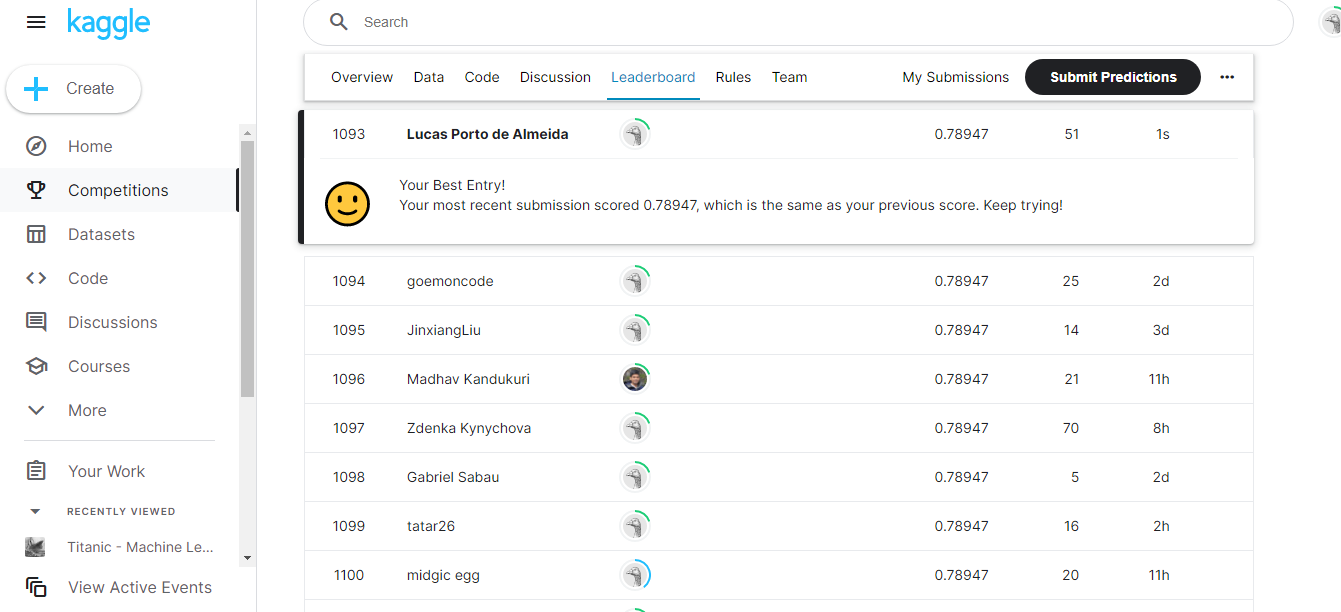

In [87]:
Image('predições.png')

Misturar os modelos gerou o mesmo score no Kaggle que fazer uso do Stacking Classifier !

## <center>5. Comentários finais<center>

<p style='text-align: justify;'>Ao longo desse projeto fizemos todo um trabalho de pré-processamento dos dados (tratamento de valores ausentes, dimensionamento de variáveis) , utilizamos engenharia de features para lidarmos com variáveis categóricas e para criarmos novas variáveis importantes para prever a sobrevivência e fizemos a modelagem através de diferentes algoritmos de Machine Learning . Após descobrirmos a acurácia de vários modelos decidimos pelo SVC e otimizamos os seus parâmetros através de pesquisa de grade. Por fim utilizamos alguns métodos de aprendizagem conjunta para melhorar a perfomance do nosso modelo como Stacking e mistura de modelos. Claro que ainda existem muitas maneiras de melhorarmos ainda mais a performance do nosso modelo : Criação de novas features, treinamento de modelos diferentes para tentar um novo Stacking ou uma nova mistura, etc . Por fim saliento que essa foi apenas uma abordagem do dataset do Titanic. Inúmeras são as possibilidades de tratar esses dados seja escolhendo modelos diferentes ou criando features distintas. 